<a href="https://colab.research.google.com/github/KayalvizhiT513/Parts-of-Speech-Tagging-HMM/blob/main/NLP_POS_tagging_using_HMMs_and_Viterbi_heuristic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NLP-POS tagging using HMMs and Viterbi heuristic

This project uses the tagged treebank corpus available as a part of the NLTK package to build a POS tagging algorithm using HMMs and Viterbi heuristic.

## 1. Exploring Treebank Tagged Corpus

In [ ]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [ ]:
# reading the Treebank tagged sentences
nltk.download('treebank')
wsj = list(nltk.corpus.treebank.tagged_sents())

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


In [ ]:
# first few tagged sentences
print(wsj[:5])

[[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')], [('Mr.', 'NNP'), ('Vinken', 'NNP'), ('is', 'VBZ'), ('chairman', 'NN'), ('of', 'IN'), ('Elsevier', 'NNP'), ('N.V.', 'NNP'), (',', ','), ('the', 'DT'), ('Dutch', 'NNP'), ('publishing', 'VBG'), ('group', 'NN'), ('.', '.')], [('Rudolph', 'NNP'), ('Agnew', 'NNP'), (',', ','), ('55', 'CD'), ('years', 'NNS'), ('old', 'JJ'), ('and', 'CC'), ('former', 'JJ'), ('chairman', 'NN'), ('of', 'IN'), ('Consolidated', 'NNP'), ('Gold', 'NNP'), ('Fields', 'NNP'), ('PLC', 'NNP'), (',', ','), ('was', 'VBD'), ('named', 'VBN'), ('*-1', '-NONE-'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('of', 'IN'), ('this', 'DT'), ('British', 'JJ'), ('industrial', 'JJ'), ('conglomerate', 'NN'), ('.', '.')], [('A', 'DT'), ('f

In [ ]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(wsj,test_size=0.3)

print(len(train_set))
print(len(test_set))
print(train_set[:5])

2739
1175
[[('Mr.', 'NNP'), ('Neuberger', 'NNP'), ('realized', 'VBD'), ('that', 'IN'), (',', ','), ('although', 'IN'), ('of', 'IN'), ('Italian', 'JJ'), ('ancestry', 'NN'), (',', ','), ('Mr.', 'NNP'), ('Mariotta', 'NNP'), ('still', 'RB'), ('could', 'MD'), ('qualify', 'VB'), ('as', 'IN'), ('a', 'DT'), ('minority', 'NN'), ('person', 'NN'), ('since', 'IN'), ('he', 'PRP'), ('was', 'VBD'), ('born', 'VBN'), ('*-1', '-NONE-'), ('in', 'IN'), ('Puerto', 'NNP'), ('Rico', 'NNP'), ('.', '.')], [('Total', 'JJ'), ('return', 'NN'), ('measures', 'VBZ'), ('price', 'NN'), ('changes', 'NNS'), ('and', 'CC'), ('interest', 'NN'), ('income', 'NN'), ('.', '.')], [('Fees', 'NNS'), ('1', 'CD'), ('3\\/4', 'CD'), ('.', '.')], [('Ballot', 'NN'), ('watchers', 'NNS'), ('say', 'VBP'), ('0', '-NONE-'), ('attention', 'NN'), ('already', 'RB'), ('is', 'VBZ'), ('focused', 'VBN'), ('*-1', '-NONE-'), ('on', 'IN'), ('the', 'DT'), ('1990', 'CD'), ('elections', 'NNS'), ('.', '.')], [('Mr.', 'NNP'), ('Edelman', 'NNP'), ('decline

In [ ]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

70745

In [ ]:
# tokens
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Mr.',
 'Neuberger',
 'realized',
 'that',
 ',',
 'although',
 'of',
 'Italian',
 'ancestry',
 ',']

In [ ]:
# vocabulary
V = set(tokens)
print(len(V))

10268


In [ ]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

45

In [ ]:
print(T)

{'MD', 'RBS', 'EX', 'VB', 'RP', 'NNP', '$', 'PRP', 'DT', ':', ',', 'WP', 'PRP$', 'LS', '.', 'IN', 'VBN', '``', 'WP$', 'WRB', "''", 'FW', 'JJR', 'VBG', 'TO', 'UH', 'VBD', 'NN', 'PDT', 'RB', '-RRB-', 'VBP', 'WDT', 'RBR', '-LRB-', 'CC', '-NONE-', 'NNS', 'CD', 'NNPS', 'JJS', '#', 'JJ', 'POS', 'VBZ'}


## 2. POS Tagging Algorithm - HMM

Hidden Markov Model based algorithm is used to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word.

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).


P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e.

P(w/t) = count(w, t) / count(t).


The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).


Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero.

### Emission Probabilities (i.e. probability of a word given a tag)

In [ ]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [ ]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)

    return (count_w_given_tag, count_tag)

### Transition Probabilities (i.e. probability of getting a tag t2 given that the tag for previous word was t1)

In [ ]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [ ]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)):
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [ ]:
tags_matrix

array([[0.        , 0.        , 0.        , ..., 0.00157233, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.6923077 , 0.        ,
        0.        ],
       [0.01754386, 0.        , 0.        , ..., 0.        , 0.        ,
        0.5614035 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.06065774, 0.        ,
        0.00121803],
       [0.        , 0.00364964, 0.        , ..., 0.19890511, 0.        ,
        0.00364964],
       [0.        , 0.        , 0.        , ..., 0.06122449, 0.        ,
        0.        ]], dtype=float32)

In [ ]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [ ]:
tags_df

,MD,RBS,EX,VB,RP,NNP,$,PRP,DT,:,...,CC,-NONE-,NNS,CD,NNPS,JJS,#,JJ,POS,VBZ
MD,0.000000,0.000000,0.000000,0.801887,0.000000,0.000000,0.000000,0.001572,0.003145,0.000000,...,0.000000,0.009434,0.000000,0.000000,0.000000,0.001572,0.000000,0.001572,0.000000,0.000000
RBS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.692308,0.000000,0.000000
EX,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.561404
VB,0.000576,0.000000,0.000000,0.000576,0.022453,0.032815,0.011514,0.031664,0.226828,0.001727,...,0.009211,0.073690,0.037997,0.018998,0.000576,0.001727,0.000000,0.090961,0.000000,0.000000
RP,0.000000,0.000000,0.000000,0.000000,0.000000,0.034722,0.013889,0.000000,0.201389,0.000000,...,0.006944,0.138889,0.048611,0.013889,0.000000,0.000000,0.000000,0.041667,0.000000,0.000000
NNP,0.010656,0.000000,0.000000,0.000761,0.000000,0.381032,0.000000,0.000304,0.002436,0.007459,...,0.038971,0.005937,0.024661,0.020399,0.018268,0.000000,0.000000,0.008373,0.047648,0.035013
$,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.990099,0.000000,0.000000,0.000000,0.009901,0.000000,0.000000
PRP,0.125207,0.000000,0.000000,0.009121,0.002488,0.002488,0.000000,0.001658,0.011609,0.002488,...,0.009950,0.037313,0.001658,0.000829,0.000000,0.000000,0.000000,0.007463,0.000000,0.189884
DT,0.001218,0.002262,0.000000,0.000000,0.000000,0.130306,0.008351,0.000348,0.001218,0.000174,...,0.000348,0.001740,0.072895,0.022965,0.003479,0.009395,0.000000,0.206681,0.000000,0.004523
:,0.014634,0.000000,0.002439,0.007317,0.000000,0.187805,0.004878,0.029268,0.117073,0.000000,...,0.056098,0.031707,0.021951,0.107317,0.000000,0.000000,0.000000,0.070732,0.000000,0.007317


In [ ]:
tags_df.loc['.', :]

,.
MD,0.000369
RBS,0.000737
EX,0.003687
VB,0.000737
RP,0.000000
NNP,0.180310
$,0.001106
PRP,0.059735
DT,0.205752
:,0.002212


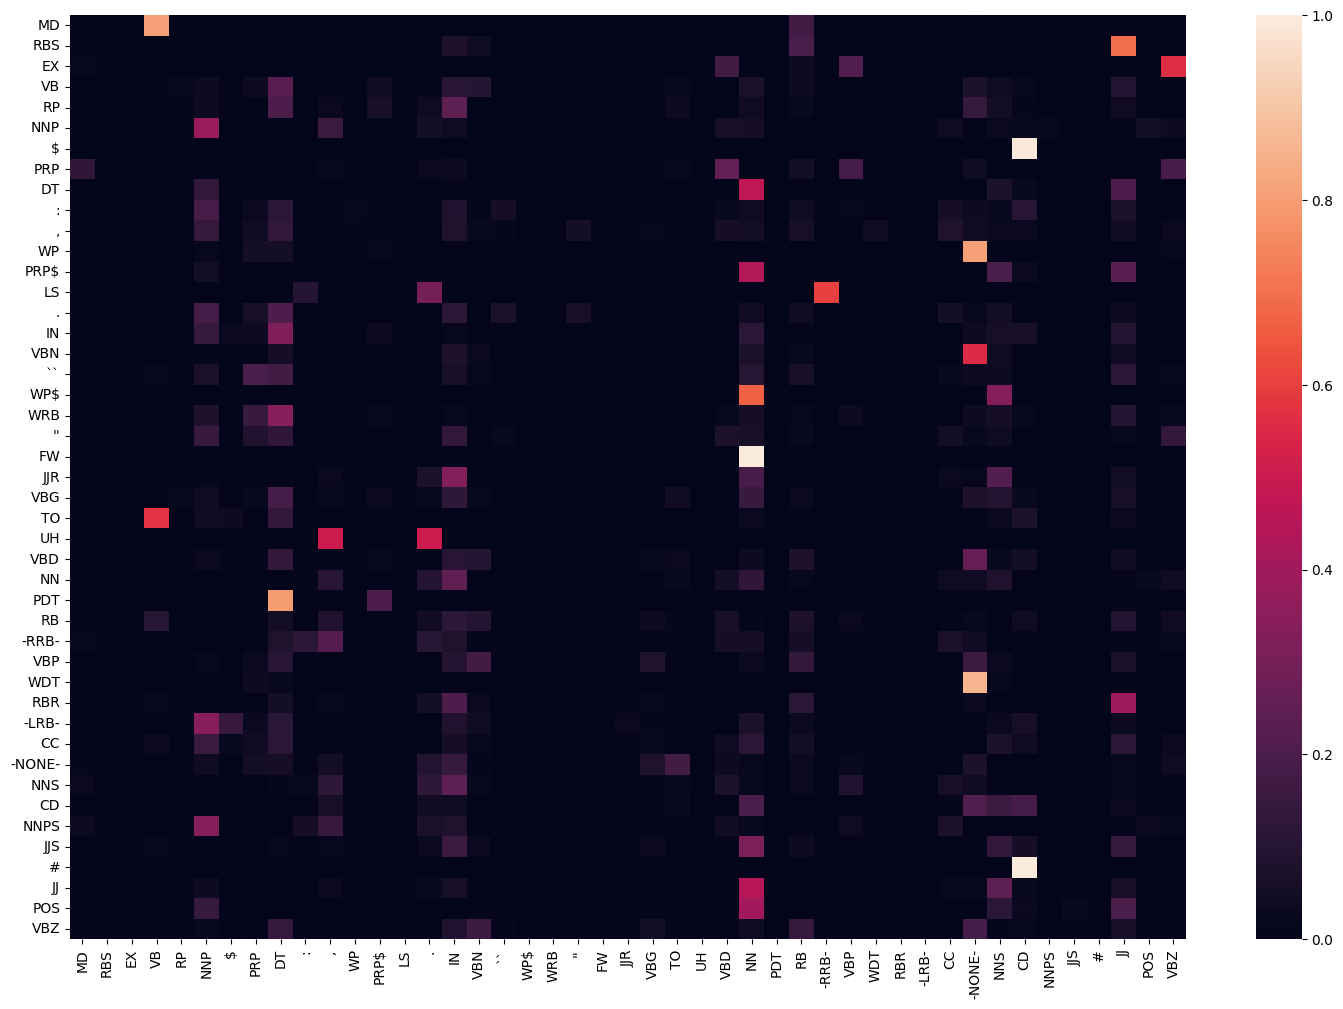

In [ ]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


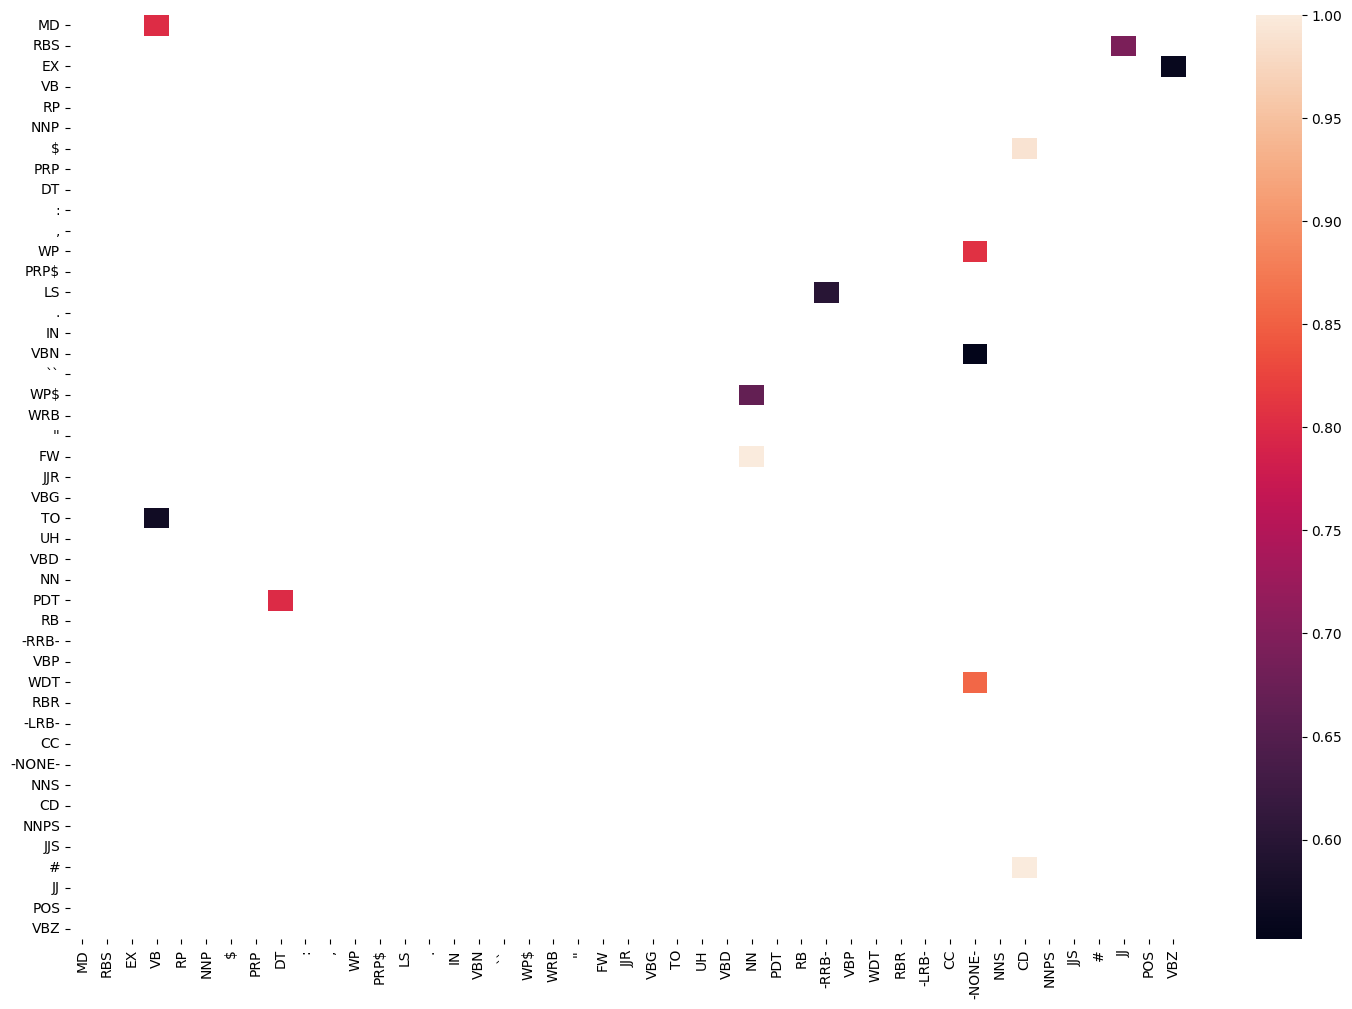

In [ ]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

## 3. Viterbi Algorithm

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.')

In [ ]:
len(train_tagged_words)

70745

In [ ]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))

    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]

            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p
            p.append(state_probability)

        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)]
        state.append(state_max)
    return list(zip(words, state))



## 4. Evaluating on Test Set

In [ ]:
# Running the Viterbi algorithm on a few sample sentences
# since running it on the entire data set will take many hours

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('Except', 'IN'),
  ('where', 'WRB'),
  ('*', '-NONE-'),
  ('noted', 'VBN'),
  ('*-3', '-NONE-'),
  ('*T*-1', '-NONE-'),
  (',', ','),
  ('none', 'NN'),
  ('of', 'IN'),
  ('these', 'DT'),
  ('people', 'NNS'),
  ('could', 'MD'),
  ('be', 'VB'),
  ('reached', 'VBN'),
  ('*-2', '-NONE-'),
  ('for', 'IN'),
  ('comment', 'NN'),
  ('or', 'CC'),
  ('had', 'VBD'),
  ('any', 'DT'),
  ('comment', 'NN'),
  ('.', '.')],
 [('The', 'DT'),
  ('$', '$'),
  ('6,500', 'CD'),
  ('*U*', '-NONE-'),
  ('tree', 'NN'),
  ('is', 'VBZ'),
  ('designed', 'VBN'),
  ('*-1', '-NONE-'),
  ('to', 'TO'),
  ('send', 'VB'),
  ('continuously', 'RB'),
  ('changing', 'VBG'),
  ('colored', 'VBN'),
  ('light', 'NN'),
  ('to', 'TO'),
  ('dozens', 'NNS'),
  ('of', 'IN'),
  ('fiber-end', 'JJ'),
  ('bunches', 'NNS'),
  ('.', '.')],
 [('The', 'DT'),
  ('latest', 'JJS'),
  ('two', 'CD'),
  ('funds', 'NNS'),
  ('were', 'VBD'),
  ('assembled', 'VBN'),
  ('*-42', '-NONE-'),
  ('jointly', 'RB'),
  ('by', 'IN'),
  ('Goldman', 'NNP'),


In [ ]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [ ]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  50.58170294761658
[('Except', 'MD'), ('where', 'MD'), ('*', '-NONE-'), ('noted', 'VBD'), ('*-3', '-NONE-'), ('*T*-1', '-NONE-'), (',', ','), ('none', 'NN'), ('of', 'IN'), ('these', 'DT'), ('people', 'NNS'), ('could', 'MD'), ('be', 'VB'), ('reached', 'VBN'), ('*-2', '-NONE-'), ('for', 'IN'), ('comment', 'NN'), ('or', 'CC'), ('had', 'VBD'), ('any', 'DT'), ('comment', 'NN'), ('.', '.'), ('The', 'DT'), ('$', '$'), ('6,500', 'MD'), ('*U*', '-NONE-'), ('tree', 'NN'), ('is', 'VBZ'), ('designed', 'VBN'), ('*-1', '-NONE-'), ('to', 'TO'), ('send', 'VB'), ('continuously', 'MD'), ('changing', 'VBG'), ('colored', 'MD'), ('light', 'JJ'), ('to', 'TO'), ('dozens', 'NNS'), ('of', 'IN'), ('fiber-end', 'MD'), ('bunches', 'MD'), ('.', 'MD'), ('The', 'DT'), ('latest', 'JJS'), ('two', 'CD'), ('funds', 'NNS'), ('were', 'VBD'), ('assembled', 'VBN'), ('*-42', '-NONE-'), ('jointly', 'RB'), ('by', 'IN'), ('Goldman', 'NNP'), (',', ','), ('Sachs', 'NNP'), ('&', 'CC'), ('Co.', 'NNP'), ('of',

In [ ]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]

In [ ]:
accuracy = len(check)/len(tagged_seq)

In [ ]:
accuracy

0.7522935779816514

In [ ]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [ ]:
incorrect_tagged_cases

[[('.', '.'), (('Except', 'MD'), ('Except', 'IN'))],
 [('Except', 'IN'), (('where', 'MD'), ('where', 'WRB'))],
 [('*', '-NONE-'), (('noted', 'VBD'), ('noted', 'VBN'))],
 [('$', '$'), (('6,500', 'MD'), ('6,500', 'CD'))],
 [('send', 'VB'), (('continuously', 'MD'), ('continuously', 'RB'))],
 [('changing', 'VBG'), (('colored', 'MD'), ('colored', 'VBN'))],
 [('colored', 'VBN'), (('light', 'JJ'), ('light', 'NN'))],
 [('of', 'IN'), (('fiber-end', 'MD'), ('fiber-end', 'JJ'))],
 [('fiber-end', 'JJ'), (('bunches', 'MD'), ('bunches', 'NNS'))],
 [('bunches', 'NNS'), (('.', 'MD'), ('.', '.'))],
 [("'s", 'POS'), (('Daiwa', 'MD'), ('Daiwa', 'NNP'))],
 [('Daiwa', 'NNP'), (('Securities', 'MD'), ('Securities', 'NNPS'))],
 [('Securities', 'NNPS'), (('Co', 'MD'), ('Co', 'NNP'))],
 [('Co', 'NNP'), (('.', 'MD'), ('.', '.'))],
 [('.', '.'), (('Seoul', 'MD'), ('Seoul', 'NNP'))],
 [('effective', 'JJ'),
  (('search-and-seizure', 'MD'), ('search-and-seizure', 'JJ'))],
 [('search-and-seizure', 'JJ'), (('procedure

In [ ]:
## Testing
sentence_test = 'The Himalayas, or Himalaya is a mountain range in Asia, separating the plains of the Indian subcontinent from the Tibetan Plateau.'
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

In [ ]:
print(tagged_seq)
print(difference)

[('The', 'DT'), ('Himalayas', 'MD'), (',', ','), ('or', 'CC'), ('Himalaya', 'MD'), ('is', 'MD'), ('a', 'DT'), ('mountain', 'MD'), ('range', 'VB'), ('in', 'IN'), ('Asia', 'NNP'), (',', ','), ('separating', 'MD'), ('the', 'DT'), ('plains', 'MD'), ('of', 'MD'), ('the', 'DT'), ('Indian', 'MD'), ('subcontinent', 'MD'), ('from', 'MD'), ('the', 'DT'), ('Tibetan', 'MD'), ('Plateau', 'MD'), ('.', 'MD')]
10.996088027954102


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True